# Dettagli ISS

Sesso, età, stato clinico.

> Max Pierini

***

Fonte dati: [EpiCentro-ISS](https://www.epicentro.iss.it/coronavirus/sars-cov-2-dashboard)

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
sns.set()

In [2]:
url = "https://www.epicentro.iss.it/coronavirus/open-data/covid_19-iss.xlsx"

# DECESSI

In [3]:
sesso_eta = pd.read_excel(
    url,
    sheet_name='sesso_eta',
    parse_dates=['iss_date']
)

In [4]:
sesso_eta.replace('<5', 5, inplace=True)

In [5]:
sesso_eta['DECEDUTI'] = sesso_eta.DECEDUTI.astype(int)

In [6]:
sesso_eta['CASI_CUMULATIVI'] = sesso_eta.CASI_CUMULATIVI.astype(int)

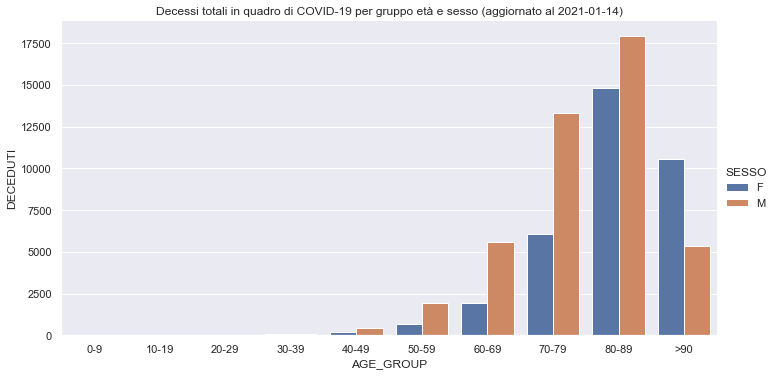

In [7]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta[(sesso_eta.AGE_GROUP!='Non noto')&(sesso_eta.SESSO!='Non noto')],
    x='AGE_GROUP', y='DECEDUTI',
    hue='SESSO',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per gruppo età e sesso "
    f"(aggiornato al {sesso_eta.iss_date.max().date()})"
)
plt.show()

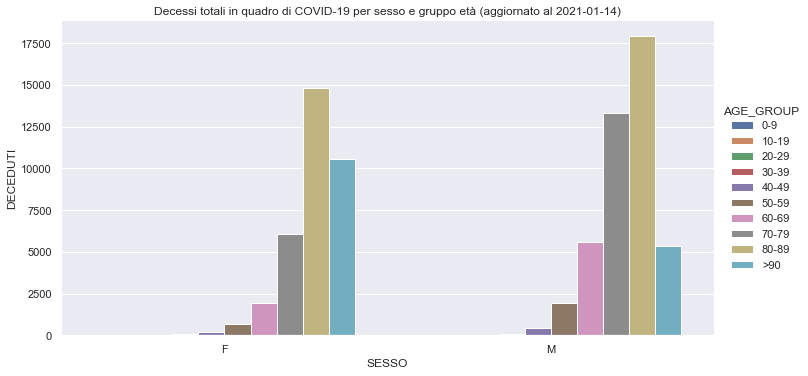

In [8]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta[(sesso_eta.AGE_GROUP!='Non noto')&(sesso_eta.SESSO!='Non noto')],
    hue='AGE_GROUP', y='DECEDUTI',
    x='SESSO',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per sesso e gruppo età "
    f"(aggiornato al {sesso_eta.iss_date.max().date()})"
)
plt.show()

In [9]:
sesso_eta_by_sex = sesso_eta.groupby('SESSO').sum().reset_index()

sesso_eta_by_sex['PERCENTUALE'] = sesso_eta_by_sex.DECEDUTI / sesso_eta_by_sex.CASI_CUMULATIVI

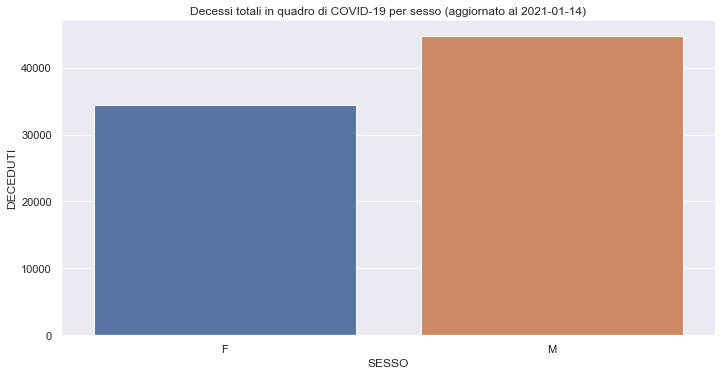

In [10]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_sex[sesso_eta_by_sex.SESSO!='Non noto'],
    x='SESSO', y='DECEDUTI',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per sesso "
    f"(aggiornato al {sesso_eta.iss_date.max().date()})"
)
plt.show()

In [11]:
sesso_eta_by_age = sesso_eta.groupby('AGE_GROUP').sum().reset_index()

sesso_eta_by_age['PERCENTUALE'] = sesso_eta_by_age.DECEDUTI / sesso_eta_by_age.CASI_CUMULATIVI

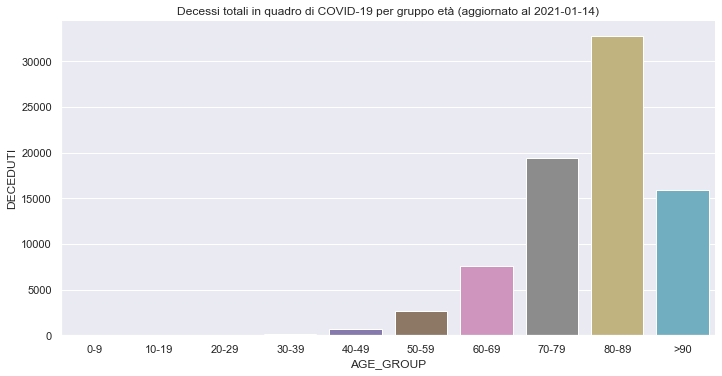

In [12]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_age[sesso_eta_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='DECEDUTI',
    aspect=2
)
g.axes.flat[0].set(
    title="Decessi totali in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {sesso_eta.iss_date.max().date()})"
)
plt.show()

# LETALITÀ

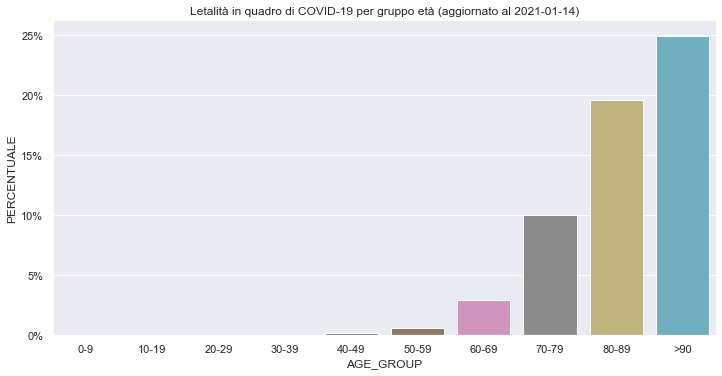

In [13]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_age[sesso_eta_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='PERCENTUALE',
    aspect=2
)
g.axes.flat[0].set(
    title="Letalità in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {sesso_eta.iss_date.max().date()})"
)
g.axes.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 0))
plt.show()

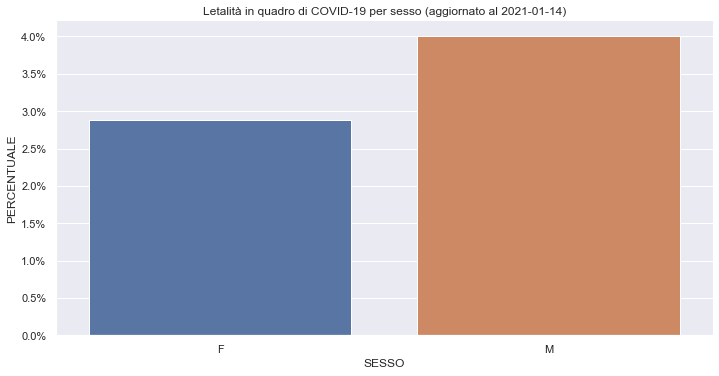

In [14]:
g = sns.catplot(
    kind='bar',
    data=sesso_eta_by_sex[sesso_eta_by_sex.SESSO!='Non noto'],
    x='SESSO', y='PERCENTUALE',
    aspect=2
)
g.axes.flat[0].set(
    title="Letalità in quadro di COVID-19 per sesso "
    f"(aggiornato al {sesso_eta.iss_date.max().date()})"
)
g.axes.flat[0].yaxis.set_major_formatter(mtick.PercentFormatter(1, 1))
plt.show()

# STATO CLINICO

In [15]:
stato_clinico = pd.read_excel(
    url,
    sheet_name='stato_clinico',
    parse_dates=['iss_date']
)

In [16]:
stato_clinico.replace('<5', 5, inplace=True)

In [17]:
stato_clinico['CASI'] = stato_clinico['CASI'].astype(int)

In [18]:
order = [
    'ASINTOMATICO',
    'PAUCI-SINTOMATICO',
    'LIEVE',
    'SEVERO',
    'CRITICO',
]

In [19]:
stato_clinico_by_sex = stato_clinico.groupby(['STATO_CLINICO', 'SESSO']).sum().reset_index()

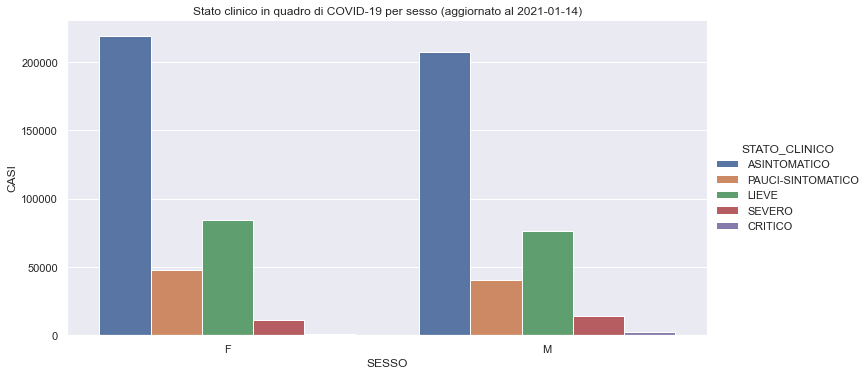

In [20]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_sex,
    x='SESSO', y='CASI',
    hue='STATO_CLINICO',
    hue_order=order,
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per sesso "
    f"(aggiornato al {stato_clinico.iss_date.max().date()})"
)
plt.show()

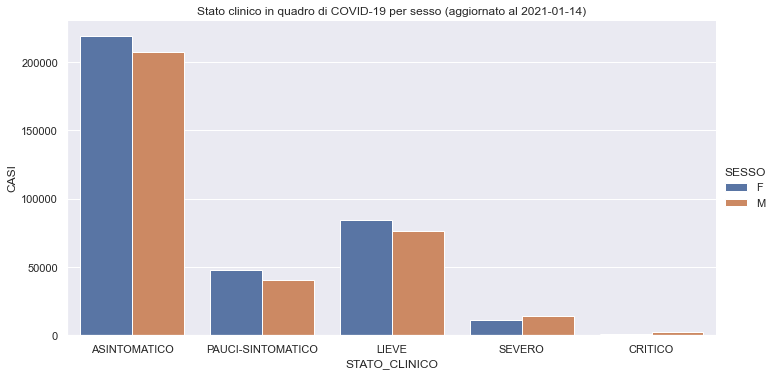

In [21]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_sex,
    x='STATO_CLINICO', y='CASI',
    hue='SESSO',
    order=order,
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per sesso "
    f"(aggiornato al {stato_clinico.iss_date.max().date()})"
)
plt.show()

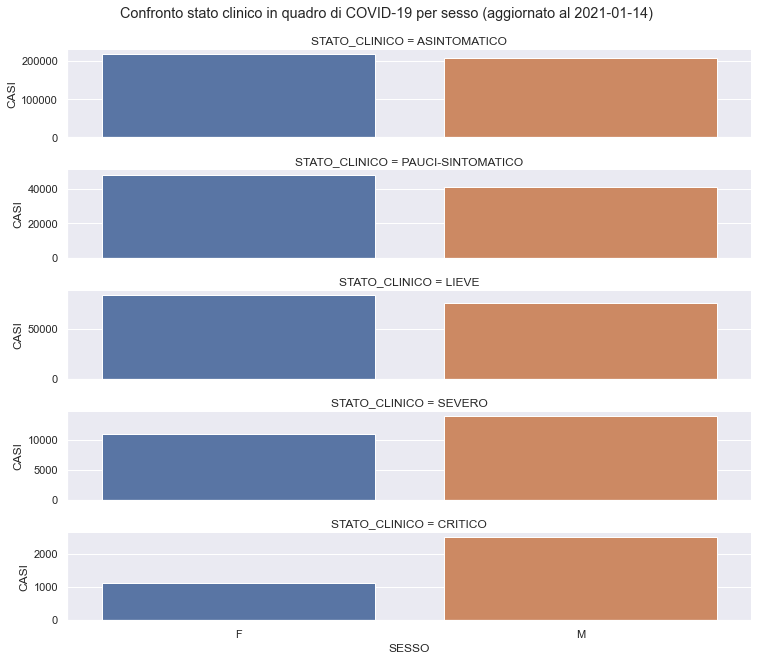

In [26]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_sex,
    x='SESSO', y='CASI',
    row='STATO_CLINICO',
    #order=order,
    #col_wrap=2,
    row_order=order,
    sharey=False,
    aspect=6, height=1.75,
)
g.fig.suptitle(
    "Confronto stato clinico in quadro di COVID-19 per sesso "
    f"(aggiornato al {stato_clinico.iss_date.max().date()})",
    y=1.025
)
plt.show()

In [22]:
stato_clinico_by_age = stato_clinico.groupby(['STATO_CLINICO', 'AGE_GROUP']).sum().reset_index()

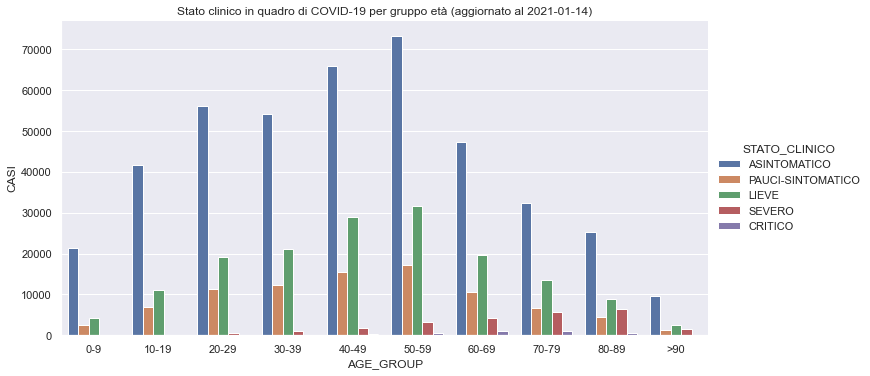

In [23]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_age[stato_clinico_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='CASI',
    hue='STATO_CLINICO',
    hue_order=order,
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {stato_clinico.iss_date.max().date()})"
)
plt.show()

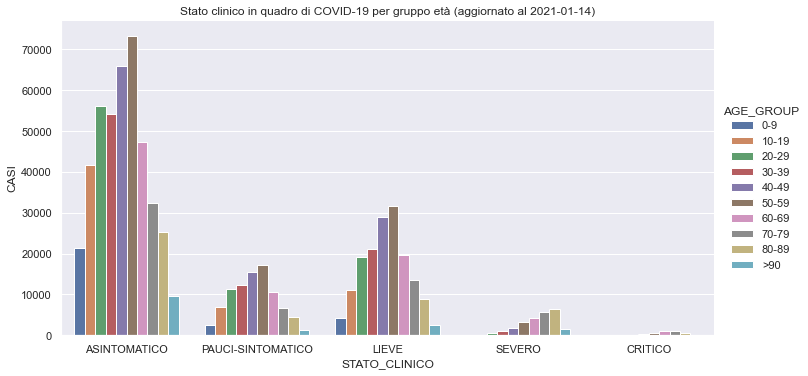

In [24]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_age[stato_clinico_by_age.AGE_GROUP!='Non noto'],
    x='STATO_CLINICO', y='CASI',
    hue='AGE_GROUP',
    order=order,
    aspect=2
)
g.axes.flat[0].set(
    title="Stato clinico in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {stato_clinico.iss_date.max().date()})"
)
plt.show()

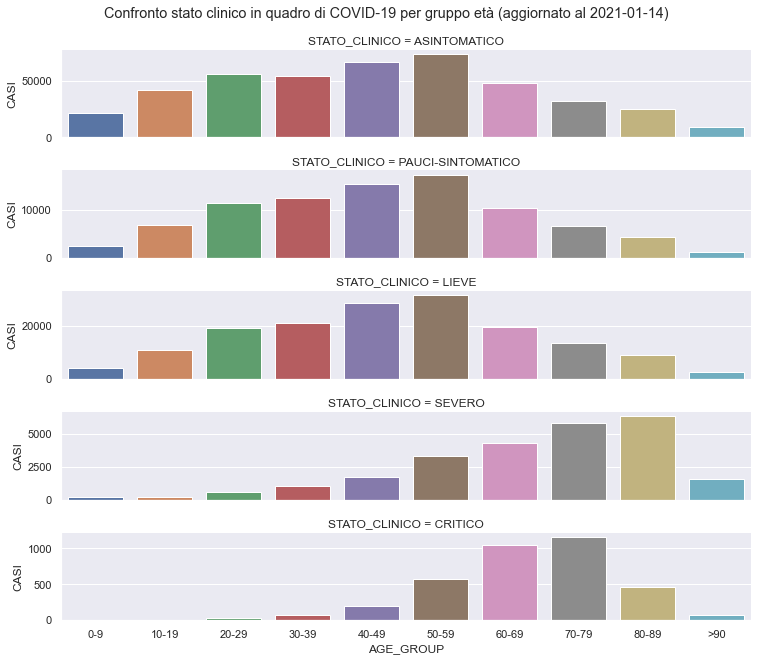

In [25]:
g = sns.catplot(
    kind='bar',
    data=stato_clinico_by_age[stato_clinico_by_age.AGE_GROUP!='Non noto'],
    x='AGE_GROUP', y='CASI',
    row='STATO_CLINICO',
    #order=order,
    #col_wrap=2,
    row_order=order,
    sharey=False,
    aspect=6, height=1.75,
)
g.fig.suptitle(
    "Confronto stato clinico in quadro di COVID-19 per gruppo età "
    f"(aggiornato al {stato_clinico.iss_date.max().date()})",
    y=1.025
)
plt.show()